Ejercicio: haz un experimento similar con Cats vs Dogs y split=['train[:50%]', 'train[80%:]']

In [ ]:
pip install tensorflow tensorflow-datasets keras-cv

  Using cached keras_cv-0.9.0-py3-none-any.whl.metadata (12 kB)
  Using cached keras_core-0.1.7-py3-none-any.whl.metadata (4.3 kB)
Using cached keras_cv-0.9.0-py3-none-any.whl (650 kB)
Using cached keras_core-0.1.7-py3-none-any.whl (950 kB)


## 1 Dataset

In [ ]:
import os; os.environ["KERAS_BACKEND"] = "tensorflow"; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np; import matplotlib.pyplot as plt
import tensorflow as tf; import tensorflow_datasets as tfds; import keras; import keras_cv
keras.utils.set_random_seed(23)
train, info = tfds.load("cats_vs_dogs", split='train', with_info=True, as_supervised=True)
print(info.description, "\n", info.splits, "\n", info.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.SFBT1Y_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
A large set of images of cats and dogs. There are 1738 corrupted images that are dropped. 
 {Split('train'): <SplitInfo num_examples=23262, num_shards=16>} 
 FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [ ]:
fig = tfds.show_examples(train, info, rows=1, cols=7)

## 2 Transfer learning

In [ ]:
import os; os.environ["KERAS_BACKEND"] = "tensorflow"; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np; import matplotlib.pyplot as plt
import tensorflow as tf; import tensorflow_datasets as tfds; import keras; import keras_cv
keras.utils.set_random_seed(23)
train, test = tfds.load("cats_vs_dogs", split=['train[:30%]', 'train[90%:]'], as_supervised=True)




In [ ]:
resize = keras_cv.layers.Resizing(224, 224, interpolation="nearest", pad_to_aspect_ratio=True)
def normalize_images(images, labels):
 return tf.cast(resize(images), tf.float32), labels
train = train.map(normalize_images, num_parallel_calls=tf.data.AUTOTUNE)
batch_size = 4; train = train.cache().shuffle(10 * batch_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test = test.map(normalize_images, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
import time; start = time.time()
inputs = keras.Input(shape=(None, None, 3))
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)
backbone = keras.applications.resnet_v2.ResNet50V2(include_top=False)
backbone.trainable = False
x = backbone(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(units=800, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.005) # la mitad del usado con CIFAR10
M.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
check = keras.callbacks.ModelCheckpoint('catdogs.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce = keras.callbacks.ReduceLROnPlateau(
 monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(train, epochs=50, validation_data=test, verbose=1, callbacks=[check, early, reduce])
print('Tiempo (hh:mm:ss):', time.strftime('%H:%M:%S', time.gmtime(time.time() - start)))


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9371 - loss: 1.5240
Epoch 1: val_accuracy improved from -inf to 0.98409, saving model to catdogs.keras
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - accuracy: 0.9371 - loss: 1.5237 - val_accuracy: 0.9841 - val_loss: 0.1076 - learning_rate: 0.0050
Epoch 2/50
1744/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9720 - loss: 0.2081
Epoch 2: val_accuracy did not improve from 0.98409
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 0.9720 - loss: 0.2080 - val_accuracy: 0.9794 - val_loss: 0.0879 - learning_rate: 0.0050
Epoch 3/50
1744/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9672 - loss: 0.5347
Epoch 3: val_accuracy did not improve from 0.98409
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.9672 - loss: 0.5346 - val_accuracy: 0.9686 - val_loss: 0.4113 - learning_rate: 0.0050
Epoch 4/50
1743/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accur

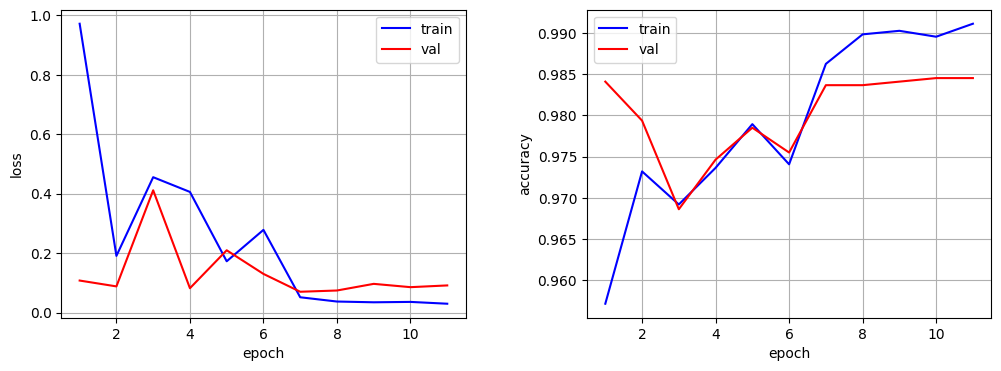

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss'); # ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], color='b', label='train')
ax.plot(xx, H.history['val_loss'], color='r', label='val'); ax.legend()
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy'); # ax.set_xticks(xx)
ax.plot(xx, H.history['accuracy'], color='b', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', label='val'); ax.legend();

## 3 Fine-tuning

In [ ]:
import os; os.environ["KERAS_BACKEND"] = "tensorflow"; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np; import matplotlib.pyplot as plt
import tensorflow as tf; import tensorflow_datasets as tfds; import keras; import keras_cv
keras.utils.set_random_seed(23)
train, test = tfds.load("cats_vs_dogs", split=['train[:30%]', 'train[90%:]'], as_supervised=True)

In [ ]:
resize = keras_cv.layers.Resizing(224, 224, interpolation="nearest", pad_to_aspect_ratio=True)
def normalize_images(images, labels):
 return tf.cast(resize(images), tf.float32), labels
train = train.map(normalize_images, num_parallel_calls=tf.data.AUTOTUNE)
batch_size = 4; train = train.cache().shuffle(10 * batch_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test = test.map(normalize_images, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)


In [ ]:
import time; start = time.time()
M = keras.models.load_model('catdogs.keras')
for layer in M.layers:
 if not isinstance(layer, keras.layers.BatchNormalization):
  layer.trainable = True
opt = keras.optimizers.Adam(learning_rate=5e-6)
M.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
check = keras.callbacks.ModelCheckpoint('catdogsft.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce = keras.callbacks.ReduceLROnPlateau(
 monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(train, epochs=100, validation_data=test, verbose=1, callbacks=[check, early, reduce])
print('Tiempo (hh:mm:ss):', time.strftime('%H:%M:%S', time.gmtime(time.time() - start)))


Epoch 1/100
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8743 - loss: 0.3343
Epoch 1: val_accuracy improved from -inf to 0.96088, saving model to catdogsft.keras
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 220s 93ms/step - accuracy: 0.8743 - loss: 0.3343 - val_accuracy: 0.9609 - val_loss: 0.1055 - learning_rate: 5.0000e-06
Epoch 2/100
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9358 - loss: 0.1730
Epoch 2: val_accuracy improved from 0.96088 to 0.96862, saving model to catdogsft.keras
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 111s 63ms/step - accuracy: 0.9358 - loss: 0.1730 - val_accuracy: 0.9686 - val_loss: 0.1061 - learning_rate: 5.0000e-06
Epoch 3/100
1744/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9691 - loss: 0.0955
Epoch 3: val_accuracy improved from 0.96862 to 0.97334, saving model to catdogsft.keras
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 143s 64ms/step - accuracy: 0.9691 - loss: 0.0955 - val_accuracy: 0.9733 - val_loss: 0.0929 - learning_rate: 5.0000e-06
Epoch 4/100
1744/17

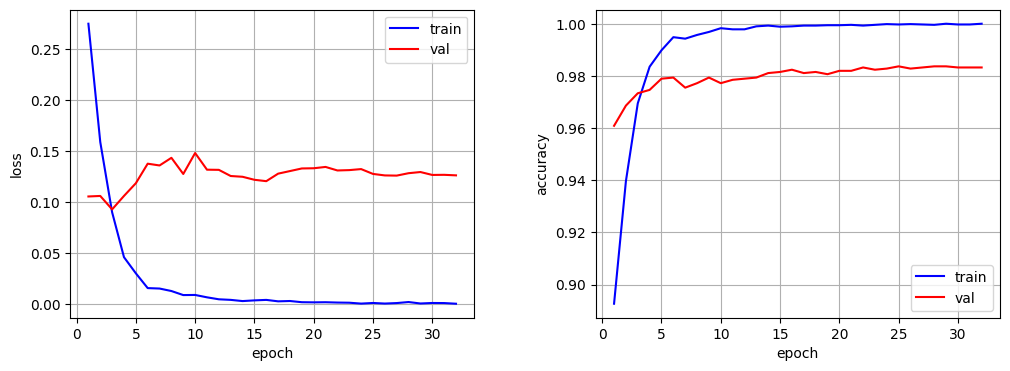

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss'); # ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], color='b', label='train')
ax.plot(xx, H.history['val_loss'], color='r', label='val'); ax.legend()
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy'); # ax.set_xticks(xx)
ax.plot(xx, H.history['accuracy'], color='b', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', label='val'); ax.legend();

## 4 Aumento de datos

In [ ]:
import os; os.environ["KERAS_BACKEND"] = "tensorflow"; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np; import matplotlib.pyplot as plt
import tensorflow as tf; import tensorflow_datasets as tfds; import keras; import keras_cv
keras.utils.set_random_seed(23)
train, test = tfds.load("cats_vs_dogs", split=['train[:30%]', 'train[90%:]'], as_supervised=True)


In [ ]:
resize = keras_cv.layers.Resizing(224, 224, interpolation="nearest", pad_to_aspect_ratio=True)
def normalize_images(images, labels):
 return tf.cast(resize(images), tf.float32), labels
random_flip = keras_cv.layers.RandomFlip("horizontal")
def augment_images(images, labels):
 return tf.cast(resize(random_flip(images)), tf.float32), labels
train = train.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
batch_size = 4; train = train.cache().shuffle(10 * batch_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test = test.map(normalize_images, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
import time; start = time.time()
M = keras.models.load_model('catdogsft.keras')
for layer in M.layers:
 if not isinstance(layer, keras.layers.BatchNormalization):
  layer.trainable = True
check = keras.callbacks.ModelCheckpoint('catdogsfta.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce = keras.callbacks.ReduceLROnPlateau(
 monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(train, epochs=100, validation_data=test, verbose=1, callbacks=[check, early, reduce])
print('Tiempo (hh:mm:ss):', time.strftime('%H:%M:%S', time.gmtime(time.time() - start)))

Epoch 1/100
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9963 - loss: 0.0122
Epoch 1: val_accuracy improved from -inf to 0.98151, saving model to catdogsfta.keras
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 242s 113ms/step - accuracy: 0.9963 - loss: 0.0122 - val_accuracy: 0.9815 - val_loss: 0.1264 - learning_rate: 4.5000e-07
Epoch 2/100
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9968 - loss: 0.0108
Epoch 2: val_accuracy did not improve from 0.98151
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 151s 63ms/step - accuracy: 0.9968 - loss: 0.0108 - val_accuracy: 0.9811 - val_loss: 0.1258 - learning_rate: 4.5000e-07
Epoch 3/100
1744/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9979 - loss: 0.0065
Epoch 3: val_accuracy improved from 0.98151 to 0.98237, saving model to catdogsfta.keras
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 130s 75ms/step - accuracy: 0.9979 - loss: 0.0065 - val_accuracy: 0.9824 - val_loss: 0.1260 - learning_rate: 4.5000e-07
Epoch 4/100
1744/1745 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/st

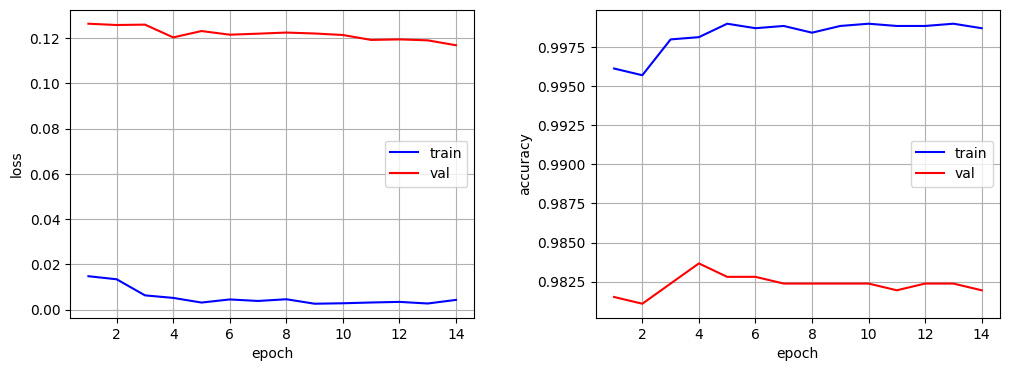

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss'); # ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], color='b', label='train')
ax.plot(xx, H.history['val_loss'], color='r', label='val'); ax.legend()
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy'); # ax.set_xticks(xx)
ax.plot(xx, H.history['accuracy'], color='b', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', label='val'); ax.legend();